This notebook contains an approach to predict the survivors of the Titanic ship sinking using an ensemble of various classification techniques. The model achieves ~85% accuracy on the training set and ~80% on the test set. Every step in the process, from getting the data to predicting the survivors is thoroughly documented and explained. 

# 1. Setting up the environment

The first step to analyzing the data is to load all the libraries we are going to use. This is performed at the start so that we can know at any point which libraries are loaded in the notebook. 

In [1]:
#Processing
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

#Misc
import os
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

%matplotlib inline

**Setting up plotting parameters:**

In [16]:
plt.style.use('seaborn')

Data file locations:

In [4]:
# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/train.csv


Now we can read the data into Pandas dataframes. A copy of the original data is kept should we require it later. Both training and test datasets are put together in a list so that we can iterate over both at the same time during data cleaning. 

In [5]:
path = Path('data')
trpath = path/'train.csv'
cvpath = path/'test.csv'

df_train_raw = pd.read_csv(trpath)
df_test_raw = pd.read_csv(cvpath)

df_train = df_train_raw.copy(deep = True)
df_test  = df_test_raw.copy(deep = True)

data_cleaner = [df_train_raw, df_test_raw]

# 2. Undestanding the Data

Let's first take a look at the first couple of rows of the training data, as well as the types of variables that the dataframe posesses and their corresponding value types.

In [6]:
df_train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
varnames = list(df_train.columns)
for name in varnames:
    print(name+": ",type(df_train.loc[1,name]))

PassengerId:  <class 'numpy.int64'>
Survived:  <class 'numpy.int64'>
Pclass:  <class 'numpy.int64'>
Name:  <class 'str'>
Sex:  <class 'str'>
Age:  <class 'numpy.float64'>
SibSp:  <class 'numpy.int64'>
Parch:  <class 'numpy.int64'>
Ticket:  <class 'str'>
Fare:  <class 'numpy.float64'>
Cabin:  <class 'str'>
Embarked:  <class 'str'>


The variables included in the data are:

* ***PassengerId***: Passenger index
* Survived: Whether the passenger in the accident. Possible values:
    * 0 = died , 
    * 1 = survived
* ***Pclass***: Passenger class. Possible values:
    * 1 = First class
    * 2 = Second class
    * 3 = Third class
* ***Name***: Passenger name
* ***Sex***: Passenger gender. Possible values:
    * male
    * female
* ***Age***: Passenger Age
* ***SibSp***: Number of siblings/spouses on board
* ***Parch***: Number of parents/children on board
* ***Ticket***: Ticket number
* ***Fare***: Ticket cost
* ***Cabin***: Cabin number
* ***Embarked***: Port of Embarkation. Possible values:
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

It is very important to understand whether and where there are missing values in the data (both train and test). This will help us determine a strategy for filling in the missing values.

In [9]:
print("Training Set")
print(df_train.isnull().sum(axis=0))
print("Test Set")
print(df_test.isnull().sum(axis=0))

Training Set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test Set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Missing values in training set: 


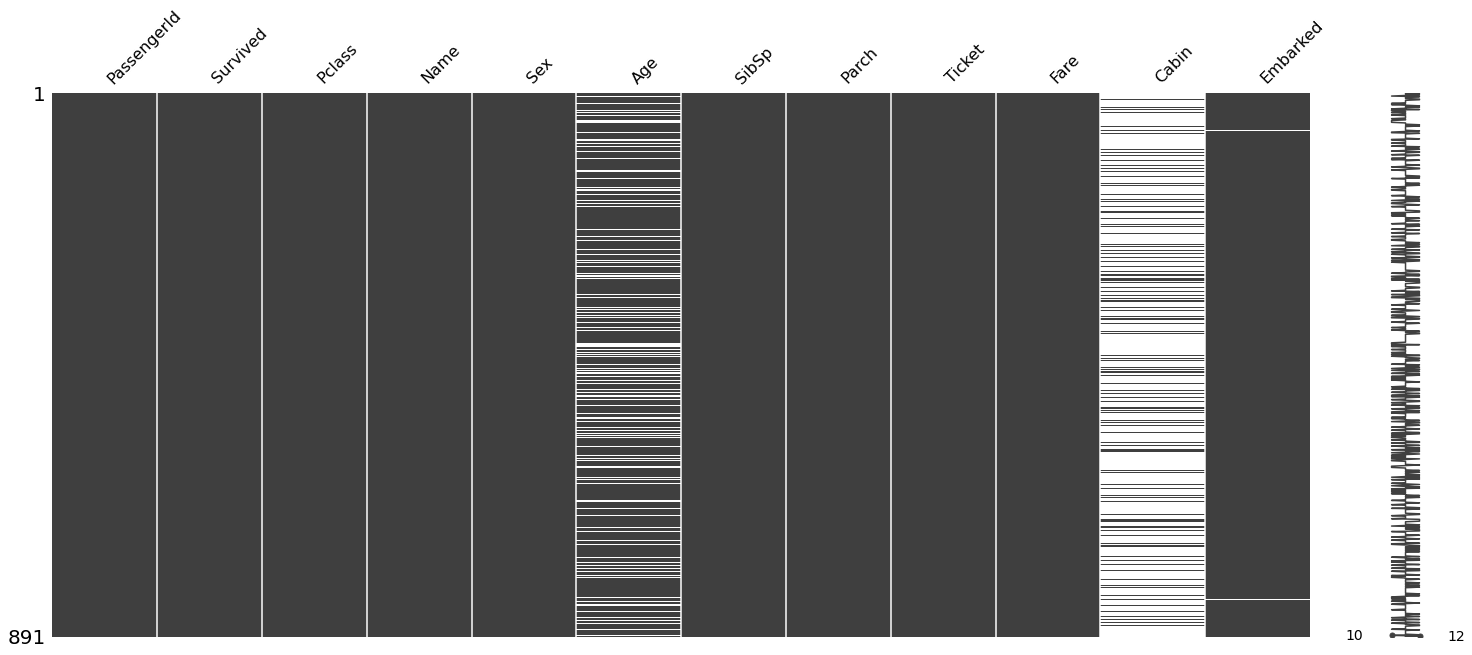

In [12]:
print("Missing values in training set: ")
msno.matrix(df_train)

Missing values in test set: 


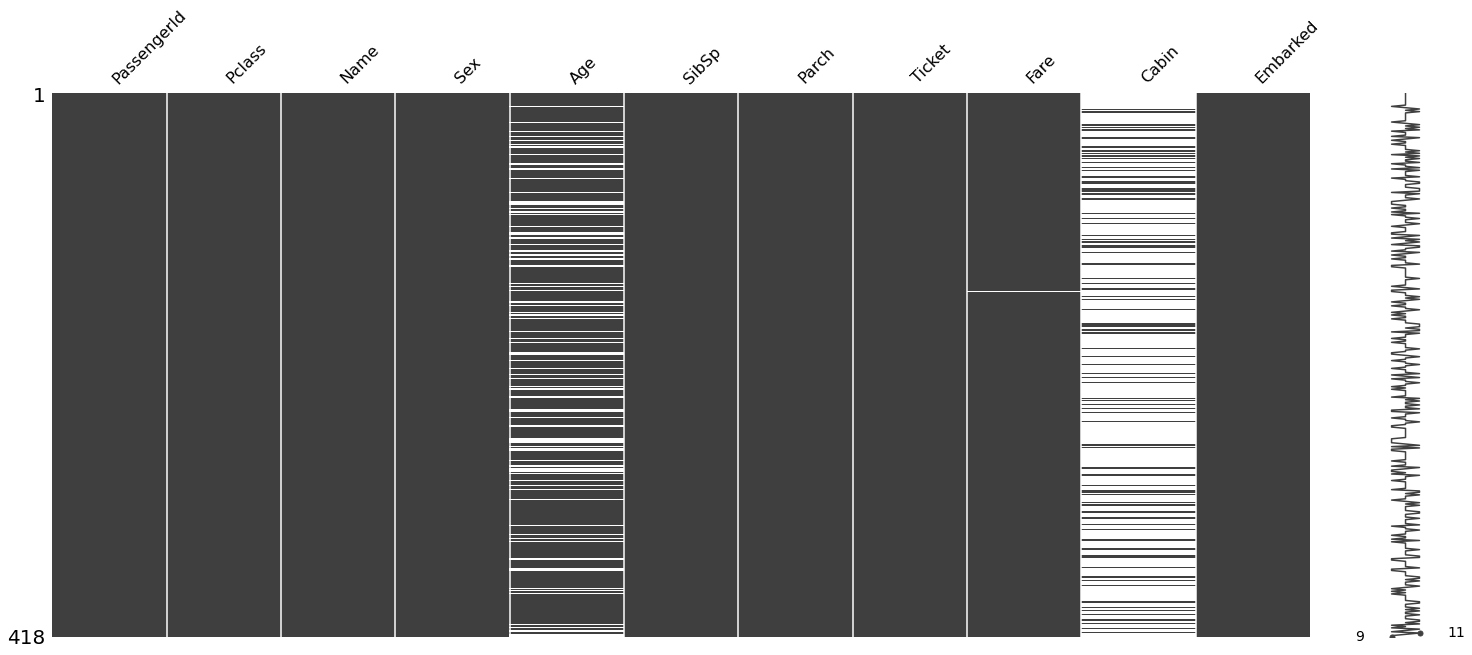

In [14]:
print("Missing values in test set: ")
msno.matrix(df_test)

We can see that there are 2 major categories with missing data, as well as a couple of missing values in other two.

**Major missing value variables: **
* Age
* Cabin

**Minor missing value variables: **
* Fare
* Embarked

# 3. Exploratory Data Analysis

Before we start cleaning up the data, it is important to see which variables are of relevance, which can be ignored  and what is the most appropriate way to fill in the missing values. As we can see in the charts above, there are 3 variables with missing values in the training set (Age,Cabin and Embarked) and only 2 in the test set (Age,Cabin). In the test set, there is also 1 fare entry missing, which we will fill later on. We shall now try and decide what we are going to do with those values.

In [15]:
print('Overall survival quota:')
df_train['Survived'].value_counts(normalize = True)

Overall survival quota:


0    0.616162
1    0.383838
Name: Survived, dtype: float64

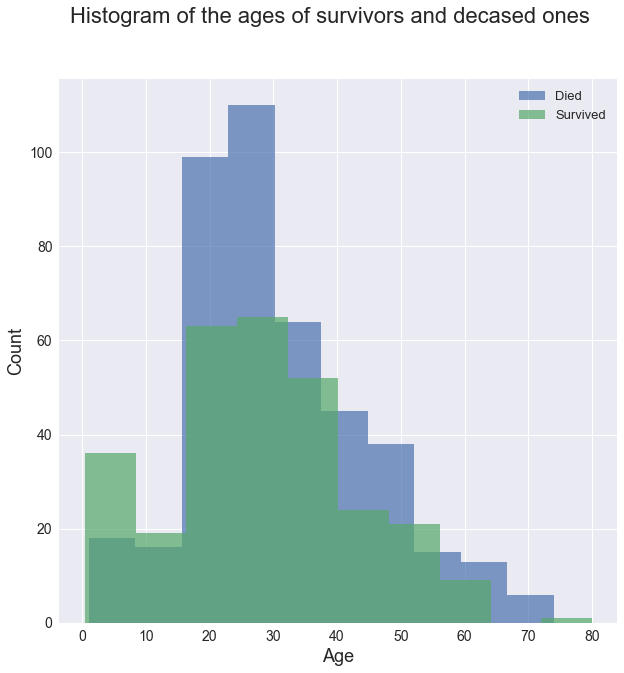

In [17]:
fig = df_train.groupby('Survived')['Age'].plot.hist(histtype= 'bar',
                                                    alpha = 0.7,
                                                    fontsize = 14,
                                                    figsize = [10,10])
plt.legend(('Died','Survived'), fontsize = 13)
plt.xlabel('Age', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.suptitle('Histogram of the ages of survivors and decased ones',fontsize =22)
plt.show()

We see that the ages distribution between those who survived and those who did not is similar. We see, however, that more young-aged passengers were saved. This was expected, since it lines up with ship evacuation policies. Other than that, age is probably not a major factor that determined who survived the accident.

Let's now explore the impact that the amount of relatives on board had on survival. For that, we create a new feature called 'Family onboard', which is the sum of parents/children/siblings/spouses (variables Parch and SibSp).

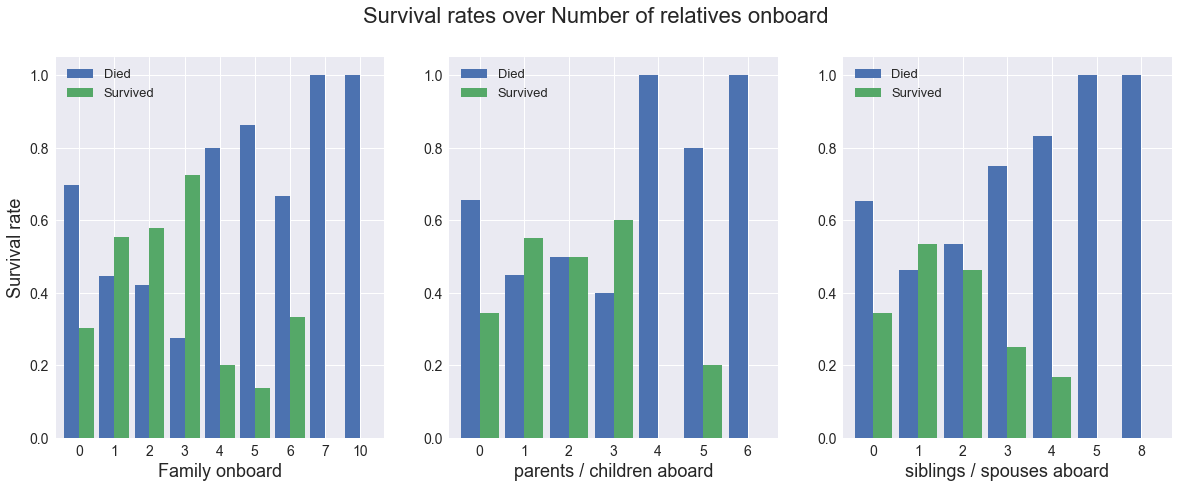

In [18]:
df_train['Family onboard'] = df_train['Parch'] + df_train['SibSp']
plt.rcParams['figure.figsize'] = [20, 7]

fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].set_ylabel('Survival rate',fontsize = 18)
axes = iter(axes.flatten())

titles = iter(['Family onboard','parents / children aboard','siblings / spouses aboard'])
family_vars = ['Family onboard','Parch','SibSp']

for var in family_vars:
    ax = next(axes)
    df_train.groupby(var)['Survived'].value_counts(normalize = True).unstack().plot.bar(ax = ax, width = 0.85, fontsize = 14)
    ax.set_xlabel(next(titles),fontsize = 18)
    ax.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
    plt.sca(ax)
    plt.xticks(rotation=0)

plt.suptitle('Survival rates over Number of relatives onboard',fontsize =22)
plt.show()

We see a clear trend that passengers with a family size between 1 and 3 had the higher the chance of survival. They are the only columns where the survivors are more than the deceased ones. Family size also combines the other 2 variables nicely and gives a more clear picture of the survival chances. Therefore, we conclude that this is an interesting feature to include in our training data.

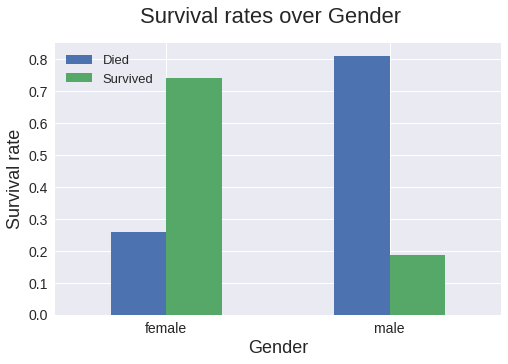

In [52]:
fig = df_train.groupby(['Sex'])['Survived'].value_counts(normalize=True).unstack().plot.bar(figsize = [8,5], width = 0.5,fontsize = 14)
plt.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
plt.xlabel('Gender',fontsize =18)
plt.xticks(rotation=0)
plt.ylabel('Survival rate',fontsize = 18)

plt.suptitle('Survival rates over Gender',fontsize =22)
plt.show()

We also see that female passengers had a higher chance of survival than male ones. It was expected that females and children would be more likely to survive, as the evacuation protocol of the ship was instructing accordingly. Let us now compare the survival chances and the passengers' ticket class.

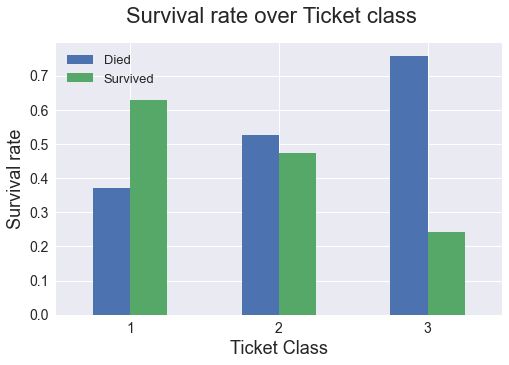

In [19]:
fig = df_train.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack().plot.bar(figsize = [8,5], width = 0.5, fontsize = 14)
plt.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
plt.xlabel('Ticket Class',fontsize =18)
plt.ylabel('Survival rate',fontsize = 18)
plt.suptitle('Survival rate over Ticket class', fontsize = 22)
plt.xticks(rotation=0)
plt.show()

As expected, first class passengers have a higher survival rate, meaning they were either given priority during evacuation or they were closer to the lifeboats. THis can be double-checked through the cabin feature that will be discussed later. 

We would now to check if the title name of a person can be useful in determining whether that person survived or not. This assumption stems from the idea that people of higher status could have been given higher priority during the ship's evacuation.  Therefore, we create a new variable called 'Title'.

In [20]:
df_train['Title'] = df_train['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
varnames = list(df_train.columns)
    
print("Training set: " ,list(df_train['Title'].unique()))    
df_test['Title'] = df_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
print("Test set: " ,list(df_test['Title'].unique()))    

Training set:  ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']
Test set:  ['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']


Some of these titles can be grouped up, since they mean the same thing. For example, "Mrs", "Miss", "Ms" will be grouped together under the label "Mrs". There are also some titles that appear to actually be a name instead of a title (Mlle, Mme, Dona) that will also be mapped to the same value. "Don" is probably an abbreviation to a male name and will be mapped to "Mr". The rest of the titles denote nobility, military or clergy service and doctors. To avoid sparse categories, they are all grouped under the title 'Notable'. Finally, 'Master' is kept as a standalone title that was given to men under 26 years of age.

In [21]:
def new_titles(df):
    new_titles = dict()
    assert 'Title' in df.columns
    for key in df['Title'].unique():
        females = ['Mrs','Miss','Ms','Mlle','Mme','Dona']
        males = ['Mr','Don']
        notable = ['Jonkheer','the Countess','Lady','Sir','Major','Col','Capt','Dr','Rev','Notable']
        titles = [females,males,notable,'Master']
        newtitles = ['Mrs','Mr','Notable','Master']
        idx = [key in sublist for sublist in titles]
        idx = np.where(idx)[0] 
        new_titles[key] = newtitles[idx[0]]
    return new_titles

new_titles_dict = new_titles(df_train)
df_train['Title'] = df_train['Title'].replace(new_titles_dict)

We can now check the survival rates for each title to see if there is some useful information here.

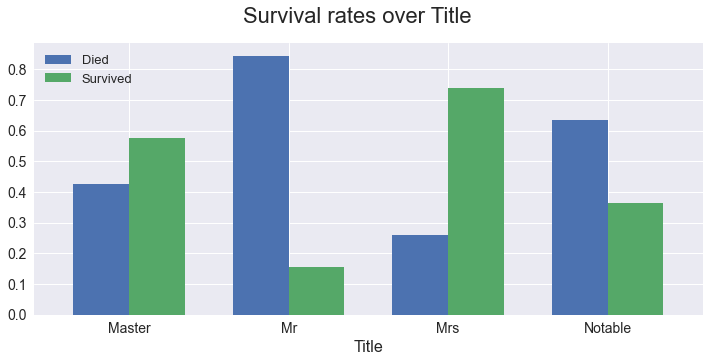

In [22]:
fig = df_train.groupby(['Title'])['Survived'].value_counts(normalize=True).unstack().plot.bar(figsize = [12,5], width = 0.7,fontsize = 14)
plt.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
plt.xlabel('Title',fontsize =16)
plt.xticks(rotation=0)

plt.suptitle('Survival rates over Title',fontsize =22)
plt.show()

Again, we see that different titles have different survival probabilities. A small surprising result is that people under the title 'Notable' have a low survival rate. One would expect that 'notable' people would travel first class and would therefore have a higher survival chance (see above), but is appears that this is not the case. This result indicates that the higher survival rates of the first class passengers have to do with their positioning on the ship. We shall now examine that. To do that, we only keep the cabin deck portion of the 'cabin' variable and, since there are a lot of missing cabin information, the missing values are denoted as 'M' for missing. 

In [23]:
df_train['Cabin'].fillna('Missing',inplace = True)
df_train['Cabin'] = df_train['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]

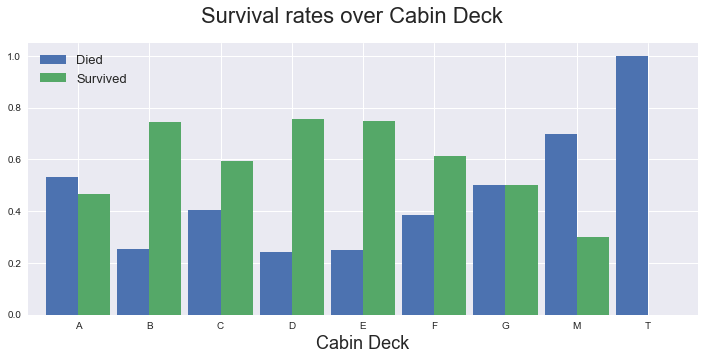

In [24]:
fig = df_train.groupby(['Cabin'])['Survived'].value_counts(normalize=True).unstack().plot.bar(figsize = [12,5], width = 0.9)
plt.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
plt.xlabel('Cabin Deck',fontsize =18)
plt.suptitle('Survival rates over Cabin Deck',fontsize =22)
plt.xticks(rotation=0)
plt.show()

We see that the cabin decks have different survival rates. As for the ones where the data was missing, the rates line up with the overall survival rate of the ship (~68%-32%).



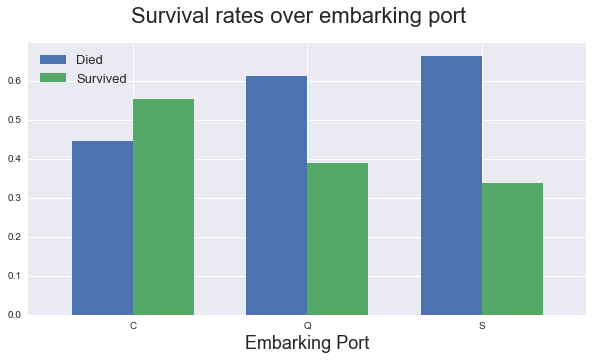

In [25]:
fig = df_train.groupby(['Embarked'])['Survived'].value_counts(normalize=True).unstack().plot.bar(figsize = [10,5], width = 0.7)
plt.legend(('Died','Survived'),fontsize = 13, loc = 'upper left')
plt.xlabel('Embarking Port',fontsize =18)
plt.suptitle('Survival rates over embarking port',fontsize =22)
plt.xticks(rotation=0)
plt.show()

Finally, we initially thought that the embarking port should be irrelevant to the task. However, passengers that embarked the ship in Cherbourg were more likely to survive. An explanation for that could be that more rich people embarked the ship and were travelling in a better class.

In [26]:
df_train.groupby(['Embarked'])['Pclass'].value_counts(normalize=True).unstack()

Pclass,1,2,3
Embarked,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


# 4. Data Cleaning

We are now going to ensure that there are no missing values in the dataset and prepare it for training our model. The 4 categories that have missing values in the train and test sets are:
* Age 
* Cabin 
* Embarked 
* Fare

In order to ease the documents' readability, any extra variables created above will be recreated here from scratch and will be encapsulated in a function. This is done to make it easier to the reader to find all feature engineering procedures in one place.

First, explore how to fill in the missing ages. Several strategies pinpoint to replace the missing values with the mean or median of the whole distribution, which in our eyes doesn't seem a good choice. Instead, let's look into the correlation of age with the other variables.

In [61]:
df_train.corr(method='pearson')['Age'].abs()

PassengerId       0.036847
Survived          0.077221
Pclass            0.369226
Age               1.000000
SibSp             0.308247
Parch             0.189119
Fare              0.096067
Family onboard    0.301914
Name: Age, dtype: float64

We see that the strongest correlation of the variable age is with the variable Pclass (passenger class). Therefore, it is appropriate to use this information in order to sample the missing ages according to the pclass. We can either take the median of each Pclass group or sample a random value from that group. Sampling from a distribution, however, seems like the more viable option, since we have a lot of missing values to replace and setting all of them to the same value would skew the distribution massively. For the other missing variables ( Fare, Embarked), the analysis we performed above leads us to believe that sampling according to the passengers' class is a viable method.

In [29]:
def df_fill(datasets, mode):
    assert mode in ['median','sampling'], "Unsupported mode"
    datasets_cp =[]
    np.random.seed(2)
    varnames = ['Age','Fare']
    for d in datasets:
        df = d.copy(deep = True)
        for var in varnames:
            idx = df[var].isnull()
            if idx.sum()>0:
                if mode =='median':
                    medians = df.groupby('Pclass')[var].median()
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = medians[df['Pclass'][i]]
                else:
                    g = df[idx==False].groupby('Pclass')[var]
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())
    #Embarked                 
        idx = df['Embarked'].isnull()
        g = df[idx==False].groupby('Pclass')['Embarked']
        for i,v in enumerate(idx):
            if v:
                df['Embarked'][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())                   
    #Cabin
        df['Cabin'][df['Cabin'].isnull()]='Missing'
        df['Cabin'] = df['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]
        datasets_cp.append(df)
    return datasets_cp

In [30]:
def prepare_data(datasets):
        datasets_cp = []
        for d in datasets:
            df = d.copy(deep = True)
            df['Family onboard'] = df['Parch'] + df['SibSp']
            df['Title'] = df['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
            new_titles_dict = new_titles(df)
            df['Title'] = df['Title'].replace(new_titles_dict)
            df.drop(columns = ['PassengerId','Name','Ticket'],axis = 1, inplace = True)
            
            datasets_cp.append(df)
        return datasets_cp      

In [32]:
train, test =prepare_data(df_fill(data_cleaner,mode = 'sampling'))  
print("Training data:")
print(train.isnull().sum())
print("Test data:")
print(test.isnull().sum())

Training data:
Survived          0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
Family onboard    0
Title             0
dtype: int64
Test data:
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
Family onboard    0
Title             0
dtype: int64


There are no more missing values in our data. The last step before training the model is to convert ordinal and nominal data to a trainable format, which is done with the help of dummy variables. To avoid colinearity, the first column of the generated dummy variables gets dropped. Additionally, the age and fare variables are normalized to minimize the impact of large values on the classification procedure.

In [33]:
ytrain = train['Survived']
xtrain = train.drop('Survived',axis = 1)
xtest = test

In [34]:
data = pd.concat([xtrain,xtest],copy =True)
sex_mapping = {'male'  : 0,
               'female': 1
              }

data = pd.get_dummies(data,columns = ['Title', 'Cabin', 'Embarked'],drop_first = True)
data['Sex'] = data['Sex'].map(sex_mapping)

m = xtrain.shape[0]
x_train = data[:m].astype('float64')
x_test = data[m:].astype('float64')
y_train = ytrain.astype('int64')

In [38]:
def normalize(df,cols,mu,sigma):
    df[cols] = (df[cols]-mu)/sigma
    return df

In [39]:
mu, sigma = x_train[['Age','Fare']].mean(), x_train[['Age','Fare']].std()

x_train = normalize(x_train,['Age','Fare'],mu, sigma)
x_test  = normalize(x_test,['Age','Fare'],mu, sigma)

# 5. Model Training

The model idea is to create 5 individual classifiers and use them as an ensemble to create the final prediction. After experimenting with various classifiers, the 5 with the best performance were chosen. These include:
* Adaboost
* Gradient Boosting Classifier
* SVC
* Random Forest Classifier
* XGBoost Classifier

The performance of each classifier is evaluated using a 5-fold cross validation strategy on the training set, where the accuracy of the classification is measured. This procedure is wrapped in the function acc_cv.

In [41]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, clone
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [42]:
n_folds = 5
def acc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(xtrain)
    acc= cross_val_score(model, x_train, y_train, scoring="accuracy", cv = kf)
    return(acc)

To find the optimal parameters for each classifier, the RandomizedSearchCV function from the sklearn library was used to find the parameters that perform best on the cross-validated training set. The parameter tuning code has been omitted to ease readability. Every classifier is preceded by the RobustScaler() function that transforms the data to reduce outliers' impact.

**Adaboost**

In [43]:
Adaboost = make_pipeline(RobustScaler(),
                         AdaBoostClassifier(base_estimator=None,
                                            n_estimators = 56,
                                            learning_rate= 0.18,
                                            algorithm='SAMME.R',
                                            random_state = 1)
                        )

**Gradient Boosting**

In [44]:
GBoosting = make_pipeline(RobustScaler(), 
                          GradientBoostingClassifier(loss='deviance',
                                                     learning_rate = 0.05,
                                                     n_estimators = 56,
                                                     min_samples_split = 9,
                                                     min_samples_leaf = 2,
                                                     max_depth = 4,
                                                     random_state = 1,
                                                     max_features = 9)
                         )

**SVC**

In [45]:
SVC =  make_pipeline(RobustScaler(), 
                     SVC(decision_function_shape = 'ovr',
                         random_state = 1,
                         max_iter = 14888,
                         kernel = 'poly',
                         degree = 2,
                         coef0 = 0.49, 
                         C =  9.6)
                     )

**Random Forest**

In [46]:
RF = make_pipeline(RobustScaler(), 
                   RandomForestClassifier(criterion='gini', 
                                          n_estimators=364,
                                          max_depth = 11,                    
                                          min_samples_split=6,
                                          min_samples_leaf=1,
                                          max_features='auto',
                                          oob_score=True,
                                          random_state=1,
                                          )
                  )

**XGB**

In [47]:
xgbc = make_pipeline(RobustScaler(), 
                     xgb.XGBClassifier(n_estimators=121,
                                       reg_lambda = 0.9,
                                       reg_alpha = 0.5,
                                       max_depth = 9,
                                       learning_rate = 0.55,
                                       gamma = 0.5,
                                       colsample_bytree = 0.4,
                                       coldsample_bynode = 0.15,
                                       colsample_bylevel = 0.5)
                    )

**Individual Scores**

In [48]:
score = acc_cv(Adaboost)
print("Adaboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = acc_cv(GBoosting)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = acc_cv(SVC)
print("SVC  score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = acc_cv(RF)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = acc_cv(xgbc)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Adaboost score: 0.8126 (0.0044)

Gradient Boosting score: 0.8238 (0.0131)

SVC  score: 0.8271 (0.0327)

Random Forest score: 0.8260 (0.0258)

Xgboost score: 0.8339 (0.0147)



To average the results of the models, a new class was created.

In [49]:
class AveragingModels(BaseEstimator):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [50]:
%%capture
averaged_models = AveragingModels(models = (Adaboost,SVC, GBoosting, RF,xgbc))
averaged_models.fit(x_train, y_train)

In [64]:
train_pred = averaged_models.predict(x_train)
test_pred = averaged_models.predict(x_test)

Since we are averaging over 5 binary classification predictions, a strategy is needed that will decide which passengers will be marked as survivors and which not. After experimenting with different strategies, it has been decided that a passenger is marked as a survivor if the majority of the classifiers have predicted so. 

In [65]:
train_pred = np.round(train_pred)
test_pred = np.round(test_pred)

acc_averaged = np.round((train_pred==y_train).sum()/train_pred.shape[0],5)
print(f"Averaged models accuracy: {acc_averaged}")

Averaged models accuracy: 0.88889


Our classifier has achieved an accuracy of ~89% percent on the training set, which is higher than the perfomance of any single classifier. Therefore, the ensembled classifiers approach has been successful.

In [232]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId'].astype('int32')
submission['Survived'] = np.floor(test_pred)
submission['Survived'] = submission['Survived'].astype('int32')
submission.to_csv('submission.csv',index=False)